# Can we beat the bookmakers?

## Load data and dependencies

In [25]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from definitions import GEN_PATH, ROOT_DIR
from utilities.helper import logger

sns.set_context('notebook')
sns.set_style('white')
sns.set(style="whitegrid")

# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])
odds_filepath = os.path.join(GEN_PATH, config['odds_filename'])

# Read data
matches = pd.read_hdf(proc_match_filepath, key='matches')
odds = pd.read_hdf(odds_filepath, key='odds')

# Initial model parameters
optimal_c = 1
lr_solver = 'lbfgs'

## Clean, prune, split matches

Only consider test matches that have odds

In [14]:
@logger
def start_pipe(df):
    return df.copy()
    
@logger
def add_odds(df, odds):
    def check_match(match, odds):
        match_date = pd.to_datetime(match['tourney_date'], unit='s')
        
        check_mask = (
           (odds['tourney_date'] == match_date) & 
            (odds['winner_id'] == match['player_1']) & 
            (odds['loser_id'] == match['player_2']))
        check = odds.loc[check_mask]
        
        if len(check) == 1:
            match['max_winner'] = check['max_w']
    
        return match
    
    df['max_winner'] = float('nan')
    df = df.apply(check_match, axis=1, args=(odds,))
    df.dropna(inplace=True)
    return df

@logger
def filter_columns(df):
    df_y = df['outcome']
    df_odds = df['max_winner']
    df_x = df.filter(['rank_diff', 'points_grad_diff', 'rel_surface_wins'])
    return df_x, df_y, df_odds

y_data = matches['outcome']
X_data = matches.drop('outcome', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

X_train = X_train.filter(['rank_diff', 'points_grad_diff', 'rel_surface_wins'])

# Only test on matches with odds
test_data = pd.concat([X_test, y_test], axis=1)

X_test, y_test, odds_test = (test_data
    .pipe(start_pipe)
    .pipe(add_odds, odds)
    .pipe(filter_columns))

start_pipe took=0:00:00.008725 shape=(39374, 18)
add_odds took=0:01:50.100393 shape=(1845, 19)
filter_columns took=0:00:00.000706 shape=(1845, 3)(1845,)(1845,)


### Train model

In [31]:
model = LogisticRegression(solver=lr_solver, C=optimal_c)
model.fit(X_train, y_train)

LogisticRegression(C=0.06, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluate betting outcome

Random Forest model accuracy on evaluated matches 65.00 %
Initial wallet: 100, avg. bets per day: 5, exposure margin: x2.4
Default probability limit: 1.0 ppm, actual default probability: 0.0018841 ppm
2019 year end profit: -100 % with avg. match profit: -0.05 %
Max lost matches in a row: 9, out of total matches: 1845
Max amount lost in a row: 28 SEK


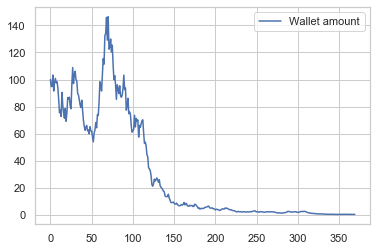

In [32]:
predictions = model.predict(X_test)
#probabilities = model.predict_proba(X_test)
#diff_prob = np.abs(probabilities[:, 0] - probabilities[:, 1])

acc = accuracy_score(y_test, predictions)
correct = predictions*y_test.to_numpy()
correct = (correct + 1) / 2
odds_returns = correct*odds_test.to_numpy()

#idx = np.argwhere(diff_prob <= 0.5)
#odds_returns = odds_returns[idx].flatten()

no_matches = len(odds_returns)
risk_limit = np.power(0.1, 6)
one_million = 1000000

weeks_of_tennis = 52 - 6  # 6 weeks downtime
avg_tournament_length = 5  # days, since most is 250 tournaments
days_of_tennis = weeks_of_tennis * avg_tournament_length
bets_per_day = round(no_matches / days_of_tennis)
avg_matches_per_day = round(no_matches / 365)

initial_wallet = 100
max_lost = 0
max_lost_amount = 0
lost = 0
lost_amount = 0
margin = 2.4  # size of margin, don't bet all at once
wallet = []
daily_wallet = [initial_wallet]

default_probability = np.power((1 - acc), (bets_per_day * margin))

for i in range(no_matches):
    r = odds_returns[i]
    
    if i == 0:
        prev_wallet = initial_wallet
    else:
        prev_wallet = wallet[i - 1]
    
    bet = prev_wallet / (bets_per_day * margin)
    wallet.append(prev_wallet - bet + r * bet)

    if r == 0:
        lost += 1
        lost_amount += bet
        
        if lost > max_lost:
            max_lost = lost
        
        if lost_amount > max_lost_amount:
            max_lost_amount = lost_amount
    else:
        lost = 0
        lost_amount = 0
    
    if i % avg_matches_per_day == 0:
        daily_wallet.append(wallet[i])
        
year_profit = wallet[-1] / initial_wallet - 1
avg_profit = year_profit / no_matches

print("Random Forest model accuracy on evaluated matches %0.2f %%" % (round(acc*100)))
print(f"Initial wallet: {initial_wallet}, avg. bets per day: {avg_matches_per_day}, exposure margin: x{margin}")
print("Default probability limit: %0.1f ppm, actual default probability: %0.7f ppm" % ((risk_limit * one_million), (default_probability * one_million)))
print("2019 year end profit: %i %% with avg. match profit: %0.2f %%" % ((round(year_profit*100), avg_profit*100)))
print(f"Max lost matches in a row: {max_lost}, out of total matches: {no_matches}")
print("Max amount lost in a row: %i SEK" % max_lost_amount)

daily_wallet = pd.DataFrame(daily_wallet, columns=['Wallet amount'])

sns.lineplot(data=daily_wallet)
plt.show()